In [26]:
%load_ext autoreload
%autoreload 2

from src.models.gps import GPS
from src.models.gcn import GCN
from src.models.explainer.explainer_pipeline import ExplainerPipeline
from src.data import loader
from src.models.model import test

from torch_geometric.explain.explainer import ModelConfig, ThresholdConfig
from torch_geometric.explain.algorithm import DummyExplainer
from torch import tensor

import networkx as nx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DummyExplainer Benchmark
- GCN
- GPS

## BAShapes
- 75 nodes
- ~300 edges
- 10 house motifs

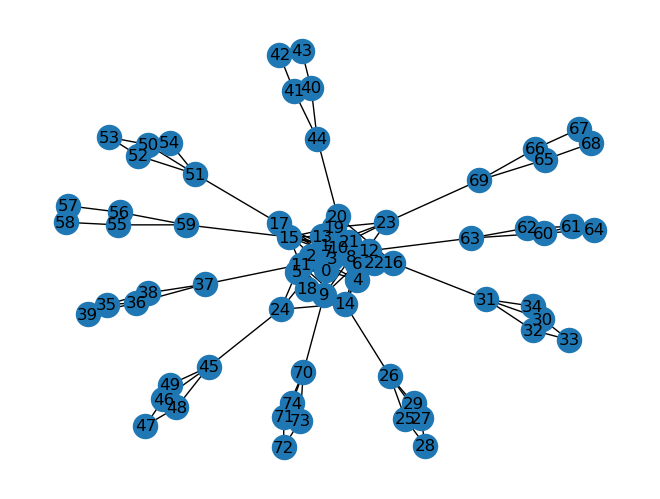

In [27]:
ba_shapes, ba_shapes_num_classes, ba_shapes_data_networkx = loader.load_clean_bashapes(num_nodes=25, num_edges=5, num_motifs=10, laplacian_eigenvector_dimensions=2)
nx.draw(ba_shapes_data_networkx, with_labels=True)

In [32]:
ba_shapes_explainer_params = {
    'explanation_type': 'model',
    'node_mask_type': 'attributes',
    'edge_mask_type': 'object',
    'model_config': ModelConfig(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    )
}

ba_shapes_explainer_pipelines = {
    "gps": ExplainerPipeline(
        ba_shapes,
        ba_shapes_num_classes,
        GPS,
        DummyExplainer,
        model_params={
            'pe_channels': 2,
            'num_layers': 4,
            'hidden_channels': 4,
            'num_attention_heads': 1,
            'observe_attention': True
        },
        explainer_params={
            **ba_shapes_explainer_params,
            "threshold_config": ThresholdConfig(threshold_type='topk', value=10)
        },
        epochs=4000
    ),
    "gcn": ExplainerPipeline(
        ba_shapes,
        ba_shapes_num_classes,
        GCN,
        DummyExplainer,
        model_params={
            "hidden_channels": 20,
            "num_layers": 3
        },
        explainer_params={
            **ba_shapes_explainer_params,
            "threshold_config": ThresholdConfig(threshold_type='topk', value=10),
        },
        epochs=4000
    )
}

100%|██████████| 4000/4000 [00:03<00:00, 1203.15it/s]


Evaluate model performance.

In [33]:
gps_train_acc, gps_test_acc = test(ba_shapes_explainer_pipelines["gps"].model, ba_shapes)
gcn_train_acc, gcn_test_acc = test(ba_shapes_explainer_pipelines["gcn"].model, ba_shapes)

print(f"GPS train accuracy: {gps_train_acc}")
print(f"GCN train accuracy: {gcn_train_acc}")

print(f"GPS test accuracy: {gps_test_acc}")
print(f"GCN test accuracy: {gcn_test_acc}")

GPS train accuracy: 0.75
GCN train accuracy: 0.6
GPS test accuracy: 0.6666666666666666
GCN test accuracy: 0.5333333333333333


Generate and evaluate explanation for node 28, which is in a house motif. Do the same for node 0, which is in the Barabasi-Albert graph.

In [34]:
nodes = [26, 0]
for model in ba_shapes_explainer_pipelines:
    for node in nodes:
        ba_shapes_explainer_pipelines[model].explain(node, laplacian_eigenvector_pe=ba_shapes.laplacian_eigenvector_pe)

Visualize GCN explanations.

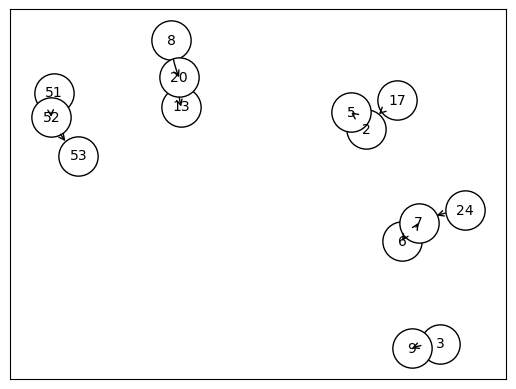

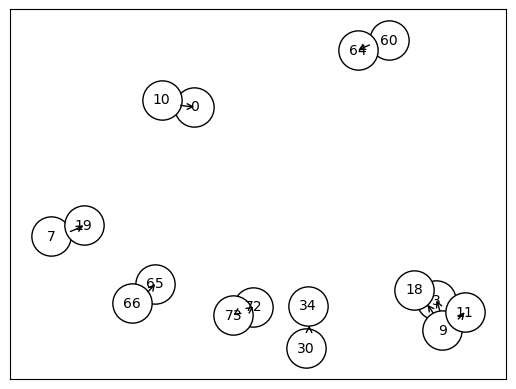

In [35]:
ba_shapes_explainer_pipelines["gcn"].explanations[26].visualize_graph()
ba_shapes_explainer_pipelines["gcn"].explanations[0].visualize_graph()

Visualize GPS explanations.

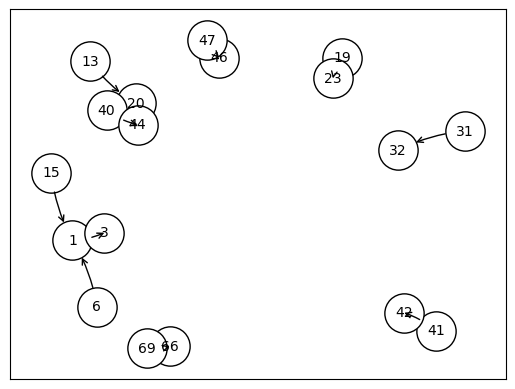

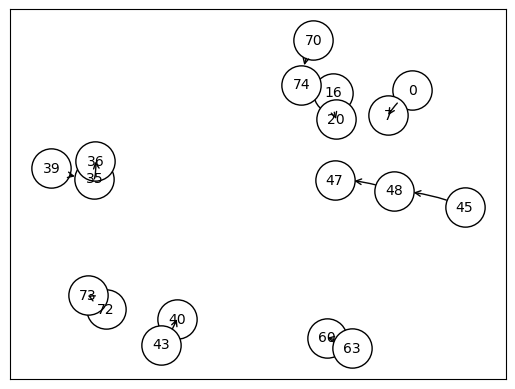

In [36]:
ba_shapes_explainer_pipelines["gps"].explanations[26].visualize_graph()
ba_shapes_explainer_pipelines["gps"].explanations[0].visualize_graph()

Evaluate explanations.

In [39]:
metrics = []
for model in ba_shapes_explainer_pipelines:
    for node in nodes:
        metrics.append([model, node, ba_shapes_explainer_pipelines[model].get_explanation_metrics(node)])

for metric in metrics:
    print(f"Model: {metric[0]}")
    print(f"Node: {metric[1]}")
    print(f"Explanation (accuracy, recall, precision, f1_score): {metric[2]}")
    print("\n")

for model in ba_shapes_explainer_pipelines:
    print(f"Model: {model}")
    pos, neg, characterization = ba_shapes_explainer_pipelines[model].get_entire_explanation_fidelity(laplacian_eigenvector_pe=ba_shapes.laplacian_eigenvector_pe, disable_tqdm=True)
    print(f"Positive explanation fidelity: {pos}")
    print(f"Negative explanation fidelity: {neg}")
    print(f"Characterization score: {characterization}")
    print("\n")


Model: gps
Node: 26
Explanation (accuracy, recall, precision, f1_score): (0.9354838728904724, 0.0, 0.0, 0.0)


Model: gps
Node: 0
Explanation (accuracy, recall, precision, f1_score): (0.8709677457809448, 0.10000000149011612, 0.03125, 0.0476190485060215)


Model: gcn
Node: 26
Explanation (accuracy, recall, precision, f1_score): (0.9354838728904724, 0.0, 0.0, 0.0)


Model: gcn
Node: 0
Explanation (accuracy, recall, precision, f1_score): (0.8709677457809448, 0.10000000149011612, 0.03125, 0.0476190485060215)


Model: gps


100%|██████████| 75/75 [00:00<00:00, 138.51it/s]


Positive explanation fidelity: 0.52
Negative explanation fidelity: 0.6933333333333334
Characterization score: 0.3858064516129032


Model: gcn


100%|██████████| 75/75 [00:00<00:00, 397.64it/s]

Positive explanation fidelity: 0.4
Negative explanation fidelity: 0.48
Characterization score: 0.45217391304347826


